In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [4]:
data = pd.read_csv("C:\\Users\\ASUS\\Downloads\\heart.csv")

In [5]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
data.shape

(303, 14)

In [7]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

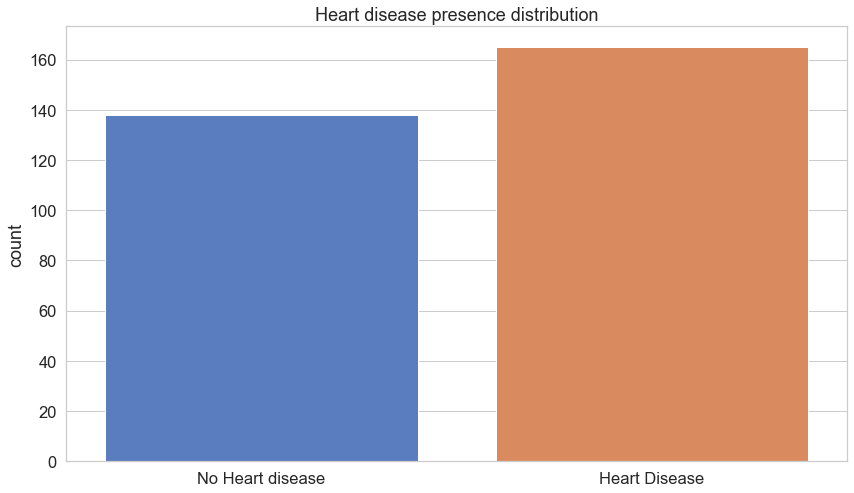

In [8]:
f = sns.countplot(x='target', data=data)
f.set_title("Heart disease presence distribution")
f.set_xticklabels(['No Heart disease', 'Heart Disease'])
plt.xlabel("");

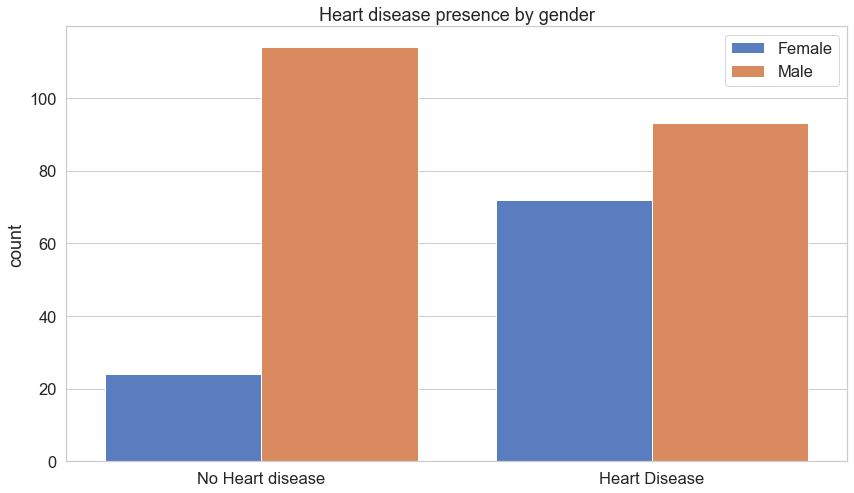

In [9]:
f = sns.countplot(x='target', data=data, hue='sex')
plt.legend(['Female', 'Male'])
f.set_title("Heart disease presence by gender")
f.set_xticklabels(['No Heart disease', 'Heart Disease'])
plt.xlabel("");

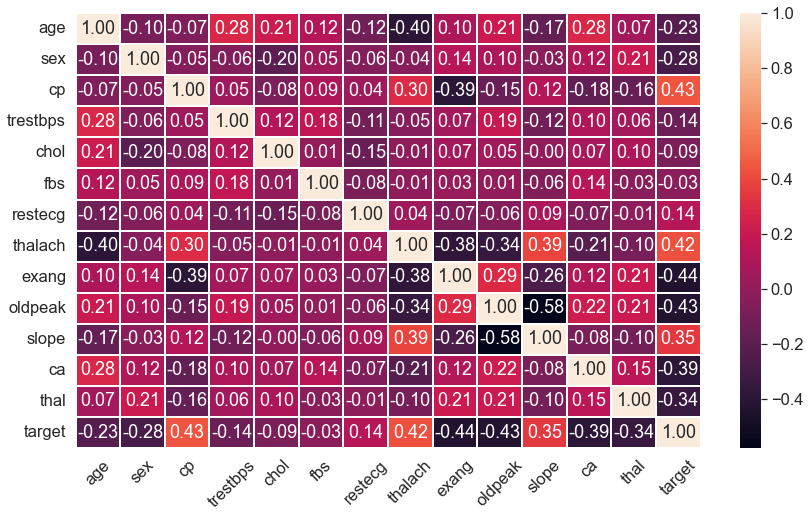

In [10]:
heat_map = sns.heatmap(data.corr(method='pearson'), annot=True, fmt='.2f', linewidths=2)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45);

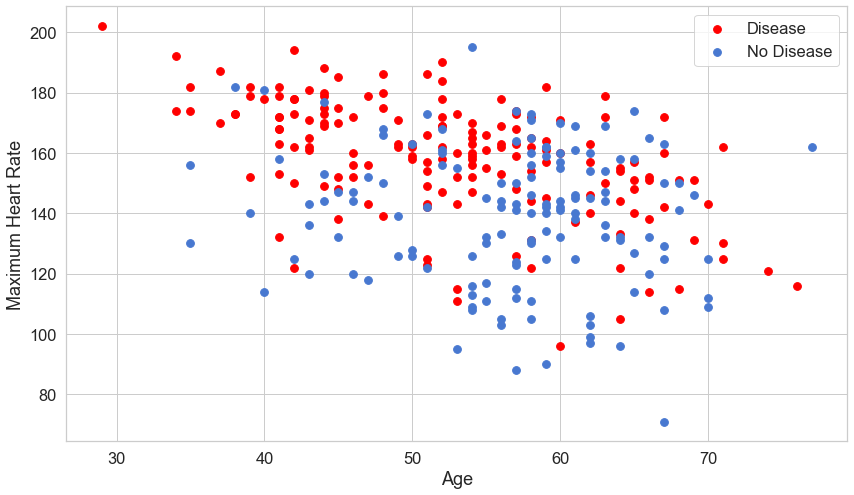

In [11]:
plt.scatter(x=data.age[data.target==1], y=data.thalach[(data.target==1)], c="red", s=60)
plt.scatter(x=data.age[data.target==0], y=data.thalach[(data.target==0)], s=60)
plt.legend(["Disease", "No Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate");

In [12]:
data['Age_Category'] = pd.cut(data['age'],bins=list(np.arange(25, 85, 5)))

Text(0.5, 1.0, 'Age Distribution of Patients with -ve Heart Diagonsis')

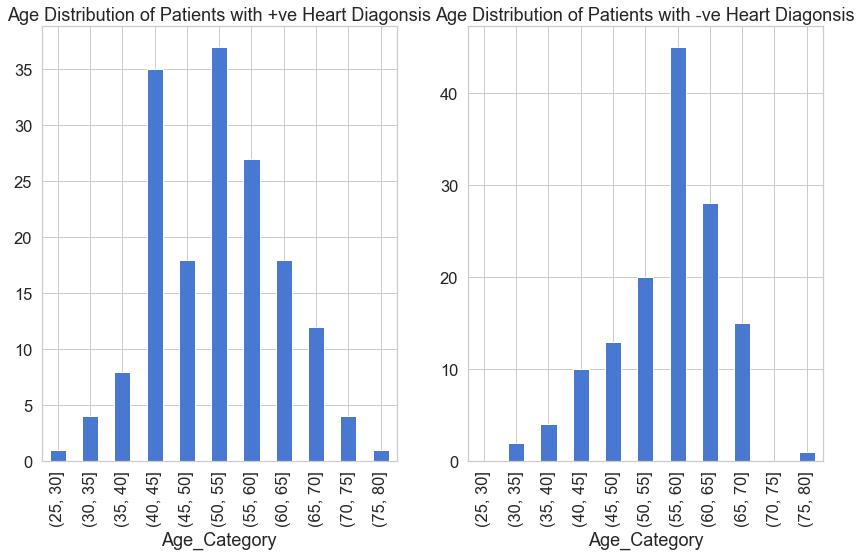

In [13]:
plt.subplot(121)
data[data['target']==1].groupby('Age_Category')['age'].count().plot(kind='bar')
plt.title('Age Distribution of Patients with +ve Heart Diagonsis')

plt.subplot(122)
data[data['target']==0].groupby('Age_Category')['age'].count().plot(kind='bar')
plt.title('Age Distribution of Patients with -ve Heart Diagonsis')

In [14]:
del data['Age_Category']

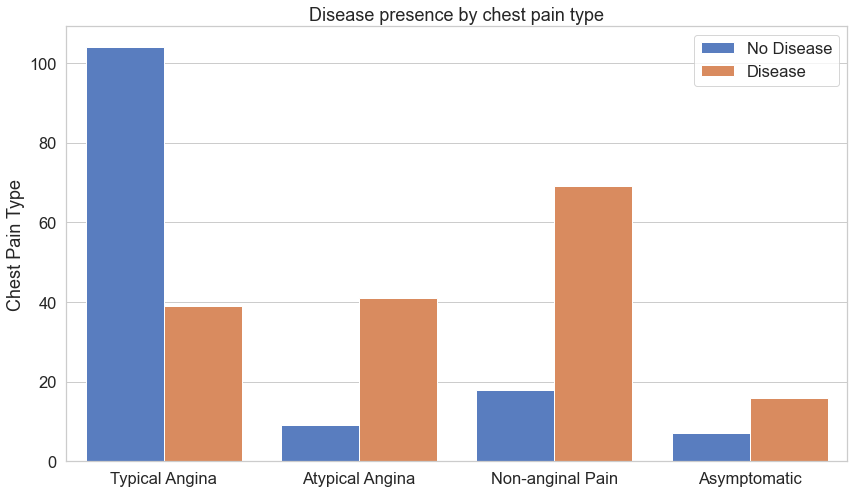

In [15]:
f = sns.countplot(x='cp', data=data, hue='target')
f.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic']);
f.set_title('Disease presence by chest pain type')
plt.ylabel('Chest Pain Type')
plt.xlabel('')
plt.legend(['No Disease', 'Disease']);

In [16]:
X = data.loc[:,data.columns!='target']
y = data.iloc[:,-1]

In [17]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [18]:
feature_columns = []

# numeric cols
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']:
  feature_columns.append(tf.feature_column.numeric_column(header))

# bucketized cols
age = tf.feature_column.numeric_column("age")
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# indicator cols
data["thal"] = data["thal"].apply(str)
thal = tf.feature_column.categorical_column_with_vocabulary_list(
      'thal', ['3', '6', '7'])
thal_one_hot = tf.feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

data["sex"] = data["sex"].apply(str)
sex = tf.feature_column.categorical_column_with_vocabulary_list(
      'sex', ['0', '1'])
sex_one_hot = tf.feature_column.indicator_column(sex)
feature_columns.append(sex_one_hot)

data["cp"] = data["cp"].apply(str)
cp = tf.feature_column.categorical_column_with_vocabulary_list(
      'cp', ['0', '1', '2', '3'])
cp_one_hot = tf.feature_column.indicator_column(cp)
feature_columns.append(cp_one_hot)

data["slope"] = data["slope"].apply(str)
slope = tf.feature_column.categorical_column_with_vocabulary_list(
      'slope', ['0', '1', '2'])
slope_one_hot = tf.feature_column.indicator_column(slope)
feature_columns.append(slope_one_hot)


# embedding cols
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# crossed cols
age_thal_crossed = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
age_thal_crossed = tf.feature_column.indicator_column(age_thal_crossed)
feature_columns.append(age_thal_crossed)

cp_slope_crossed = tf.feature_column.crossed_column([cp, slope], hash_bucket_size=1000)
cp_slope_crossed = tf.feature_column.indicator_column(cp_slope_crossed)
feature_columns.append(cp_slope_crossed)

In [19]:
def create_dataset(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  return tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) \
          .shuffle(buffer_size=len(dataframe)) \
          .batch(batch_size)

In [20]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

In [21]:
train_ds = create_dataset(train)
test_ds = create_dataset(test)

In [23]:
model = tf.keras.models.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns=feature_columns),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
  ])

In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=100, use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 3s 94ms/step - loss: 2.2493 - accuracy: 0.5124 - val_loss: 1.2105 - val_accuracy: 0.5246
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 1.3783 - accuracy: 0.5826 - val_loss: 1.1456 - val_accuracy: 0.5082
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0213 - accuracy: 0.5785 - val_loss: 0.6100 - val_accuracy: 0.6393
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 1.0004 - accuracy: 0.5496 - val_loss: 0.6789 - val_accuracy: 0.6230
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.8088 - accuracy: 0.5992 - val_loss: 0.4997 - val_accuracy: 0.7869
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.7001 - accuracy: 0.6033 - val_loss: 0.5338 - val_accuracy: 0.7377
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.6456 - accuracy: 0.6694 - val_loss: 0.4745 - val_accuracy: 0.8361
Epoch 8/100
8/8 [====

In [25]:
model.evaluate(test_ds)

2/2 [==============================] - 0s 8ms/step - loss: 0.3957 - accuracy: 0.8852


[0.39569222927093506, 0.8852459192276001]

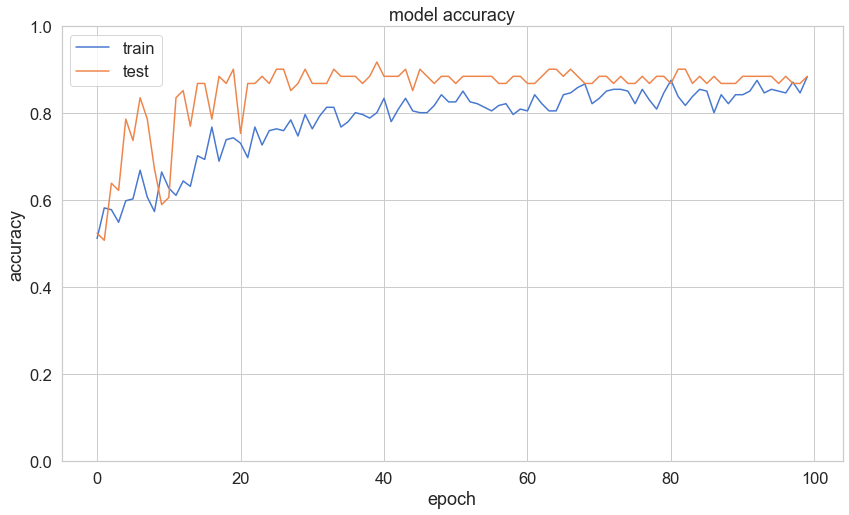

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'test'], loc='upper left');

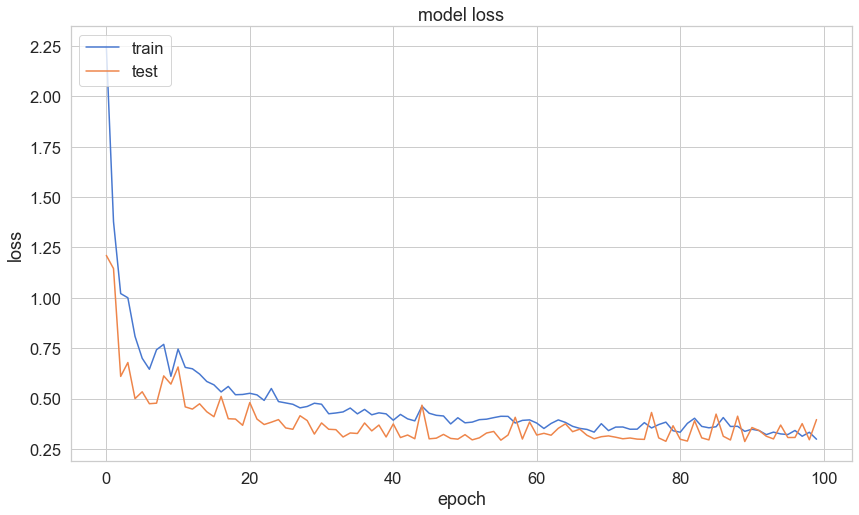

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
predictions = model.predict(test_ds)

2/2 [==============================] - 0s 0s/step


In [30]:
bin_predictions = tf.round(predictions).numpy().flatten()

In [31]:
print(classification_report(test.target, bin_predictions))

              precision    recall  f1-score   support

           0       0.50      0.55      0.52        29
           1       0.55      0.50      0.52        32

    accuracy                           0.52        61
   macro avg       0.53      0.53      0.52        61
weighted avg       0.53      0.52      0.52        61



In [32]:
cnf_matrix = confusion_matrix(test.target, bin_predictions)
cnf_matrix

array([[16, 13],
       [16, 16]], dtype=int64)

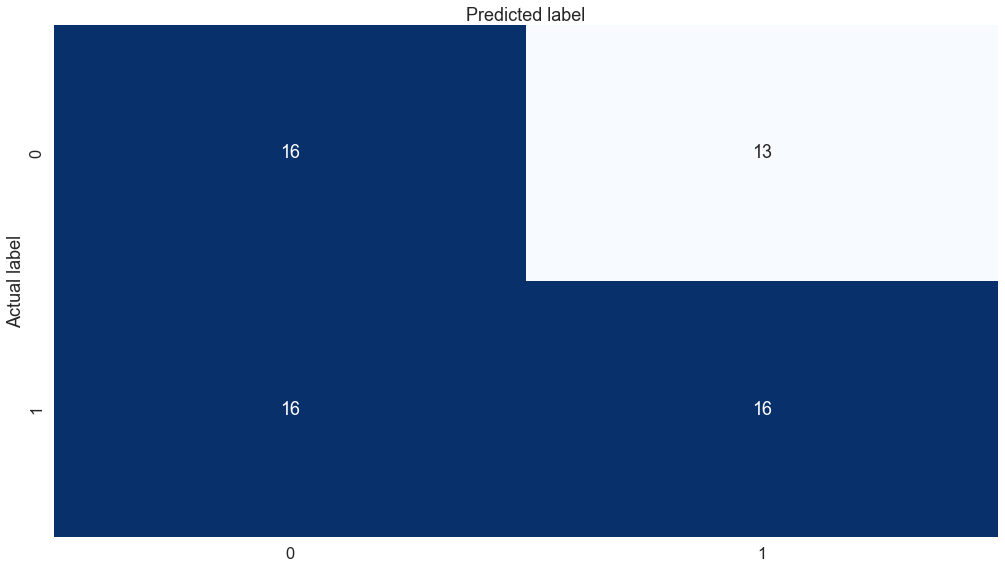

In [33]:
class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

sns.heatmap(pd.DataFrame(cnf_matrix),annot=True,cmap="Blues",fmt="d",cbar=False)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label');